In [10]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
len(df)

11914

In [4]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [6]:
# Lowercase all the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Select only columns with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Lowercase and replace spaces with underscores for values in all string columns of the dataframe
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


This dataset contains multiple columns:    
- make -- make of a car (BMW, Toyota, and so on)
- model -- model of a car
- year -- year when the car was manifactured
- engine_fuel_type -- type of the fuel the engine needs (diesel, electric and so on)
- engine_hp -- horsepower of the engine
- engine_cylinders -- number of cylinders in the engine
- transmission_type -- type of transmission (automatic or manuel)
- driven_wheels -- front, rear, all
- number of doors -- number of doors a car has
- market_category -- luxury, crossover, and so on
- vehicle_size -- compact, midsize, or large
- vehicle_style -- sedan or convertible
- highway_mpg -- miles per gallon (mpg) on the highway
- city_mpg -- miles per gallon in the city
- popularity -- number of times the car was mentioned in Twitter stream
- msrp -- manufacturer's suggested retail price

### Target variable analysis

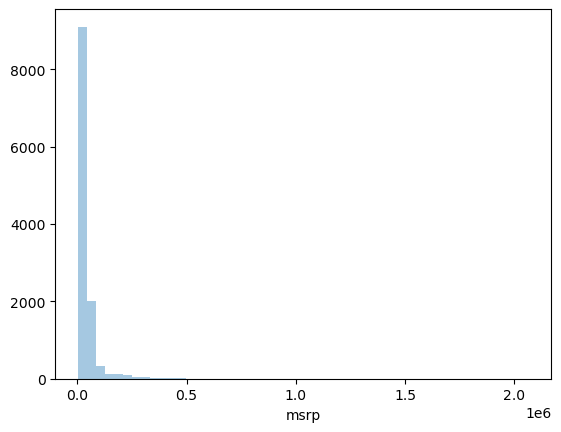

In [8]:
sns.distplot(df.msrp, kde=False)

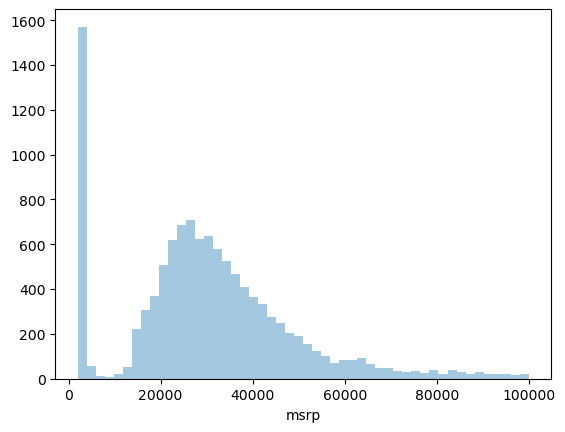

In [9]:
# To have a closer look 
sns.distplot(df.msrp[df.msrp < 100_000], kde=False)

In [12]:
# Transforming the target using BoxCox
fitted_price, fitted_lambda = sp.stats.boxcox(df.msrp)

lambda: 0.214


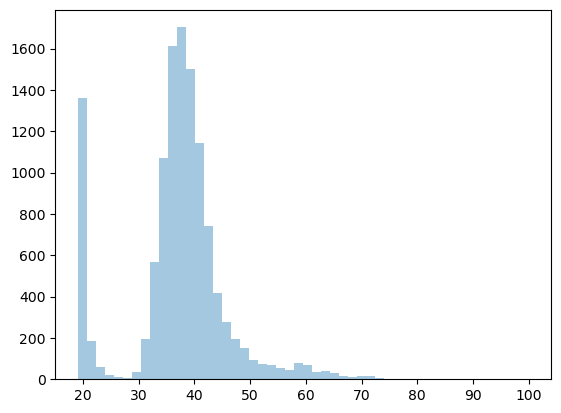

In [13]:
print("lambda: {:.3f}".format(fitted_lambda))

sns.distplot(fitted_price, kde=False)

### Checking the missing values

In [14]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Validation framework

In [15]:
# 20% of the data goes to validation
# 20% goes to test
# and the remaining 60% goes to train
n = len(df)

# Calculate how many rows should go ti train, validation and test
n_val = int(0.2 * n)
n_test = int(0.2 *n)
n_train = n - (n_val + n_test)

# Create a NumPy array with indices from 0 to (n-1) and shuffle it
np.random.seed(2) # Fix the random seed to make sure that the results are reproducible
idx = np.arange(n)
np.random.shuffle(idx)

# Use the array with idx to get a shuffle dataframe
df_shuffled = df.iloc[idx]

# Split the shuffles dataframe into train, validation and test
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [19]:
# Transforming the target using BoxCox for each dataframe
y_train = sp.stats.boxcox(df_train.msrp.values, lmbda=fitted_lambda)
y_val = sp.stats.boxcox(df_val.msrp.values, lmbda=fitted_lambda)
y_test = sp.stats.boxcox(df_test.msrp.values, lmbda=fitted_lambda)

In [20]:
# To avoid accidentally using the target later
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Linear regression

I'll implement the linear regression myself for this model

In [22]:
def linear_regression(X, y):
    # Adding the dummy column
    ones = np.ones(X.shape[0])      # Create an array that contains only 1s
    X = np.column_stack([ones, X])  # Add the array of 1s as the first column of X

    # Normal equation formula
    XTX = X.T.dot(X)                # Compute XtX
    XTX_inv = np.linalg.inv(XTX)    # Compute the inverse of XtX
    w = XTX_inv.dot(X.T).dot(y)     # Compute the rest of the normal equation

    return w[0], w[1:]              # Split the weights vector into the bias and the rest of the weights

Let's start with some quantitative features

- engine_hp
- engine_cylenders
- highway_mpg
- city_mpg
- popularity

In [23]:
# Select the features from the data frame 
base = ['engine_hp', 'engine_cylenders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

KeyError: "['engine_cylenders'] not in index"

In [ ]:
# 